In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string 
from nltk.tokenize import word_tokenize, sent_tokenize   #for tokenization
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
import gensim
from nltk import FreqDist
import collections
import re
import joblib

In [2]:
with open('Cell_Phones_and_Accessories.json') as data:
    df=json.load(data)

In [3]:
df=pd.DataFrame(df)
df.head(15)

,Rating,Rev_verify,Review_Date,IC,Prod_meta,Reviewer_Name,Review,Rev_summ,Review_timestamp,Useful,Prod_img
0,5,True,"09 1, 2015",B009XD5TPQ,None,Sunny Zoeller,Bought it for my husband. He's very happy with it,He's very happy with,1441065600,None,None
1,5,True,"01 9, 2016",B016MF3P3K,None,Denise Lesley,Great screen protector. Doesn't even seem as ...,Five Stars,1452297600,None,None
2,5,True,"04 21, 2013",B008DC8N5G,None,Emir,Saved me lots of money! it's not gorilla glass...,As long as you know how to put it on!,1366502400,None,None
3,3,True,"02 27, 2013",B0089CH3TM,{'Color:': ' Green'},Alyse,"The material and fit is very nice, but the col...",Good case overall,1361923200,3,None
4,4,True,"12 19, 2013",B00AKZWGAC,None,TechGuy,This last me about 3 days till i have to charg...,Awesome Battery,1387411200,None,None
5,5,True,"12 22, 2016",B00MAWPGMI,{'Color:': ' _Shimmery White'},hannahv_tc,"Love this case, very sturdy!",Five Stars,1482364800,None,None
6,5,False,"08 1, 2016",B00NB7B4GI,None,Nadia,Simple and good quality iPhone 6 case. Fits on...,Simple and good quality iPhone 6 case,1470009600,None,None
7,5,True,"06 22, 2015",B00NMR6N7W,"{'Color:': ' Clear', 'Package Type:': ' Standa...",Jacob,Great screen protector for the money! Paid $1....,Perfect!,1434931200,None,None
8,5,True,"08 13, 2017",B018V60504,{'Color:': ' Black'},Metlman,"Nice charger. One problem, one if the two USB ...",Make sure your Items work before you miss the ...,1502582400,None,None
9,5,False,"04 2, 2015",B00PG8TID6,"{'Color:': ' Black', 'Product Packaging:': ' S...",A. Burke,Most battery packs for iPhones come as a total...,This clever design combines a battery pack int...,1427932800,None,None


In [4]:
df.dtypes

Rating               int64
Rev_verify            bool
Review_Date         object
IC                  object
Prod_meta           object
Reviewer_Name       object
Review              object
Rev_summ            object
Review_timestamp     int64
Useful              object
Prod_img            object
dtype: object

In [5]:
#changing the data type of column Review_Date to date_time format
df['Review_Date']=pd.to_datetime(df['Review_Date'])

In [6]:
df.shape

(760450, 11)

In [7]:
df.columns

Index(['Rating', 'Rev_verify', 'Review_Date', 'IC', 'Prod_meta',
       'Reviewer_Name', 'Review', 'Rev_summ', 'Review_timestamp', 'Useful',
       'Prod_img'],
      dtype='object')

In [8]:
#null value checking
df.isnull().sum()

Rating                   0
Rev_verify               0
Review_Date              0
IC                       0
Prod_meta           352624
Reviewer_Name           91
Review                 530
Rev_summ               355
Review_timestamp         0
Useful              698250
Prod_img            742256
dtype: int64

In [9]:
#dropping 'Prod_img' and 'Useful' columns as they have more than 90% null values
#dropping 'Review_timestamp' column as it contain unix time and we already have a column for time
prod=df.drop(['Prod_img','Useful','Review_timestamp'],axis=1)

In [10]:
#dropping null values
prod.dropna(inplace=True)

In [11]:
print('Earlier Shape was= ',df.shape,'\nNew shape=',prod.shape)

Earlier Shape was=  (760450, 11) 
New shape= (407303, 8)


In [12]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 407303 entries, 3 to 760448
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Rating         407303 non-null  int64         
 1   Rev_verify     407303 non-null  bool          
 2   Review_Date    407303 non-null  datetime64[ns]
 3   IC             407303 non-null  object        
 4   Prod_meta      407303 non-null  object        
 5   Reviewer_Name  407303 non-null  object        
 6   Review         407303 non-null  object        
 7   Rev_summ       407303 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(5)
memory usage: 25.2+ MB


In [13]:
prod.columns

Index(['Rating', 'Rev_verify', 'Review_Date', 'IC', 'Prod_meta',
       'Reviewer_Name', 'Review', 'Rev_summ'],
      dtype='object')

In [14]:
#rearranging the columns
prod=prod[['IC','Reviewer_Name','Prod_meta','Review','Rev_summ','Rating','Review_Date','Rev_verify']]

Text(0.5, 1.0, 'PLOT TO SEE THE COUNT OF VARIOUS RATINGS\n')

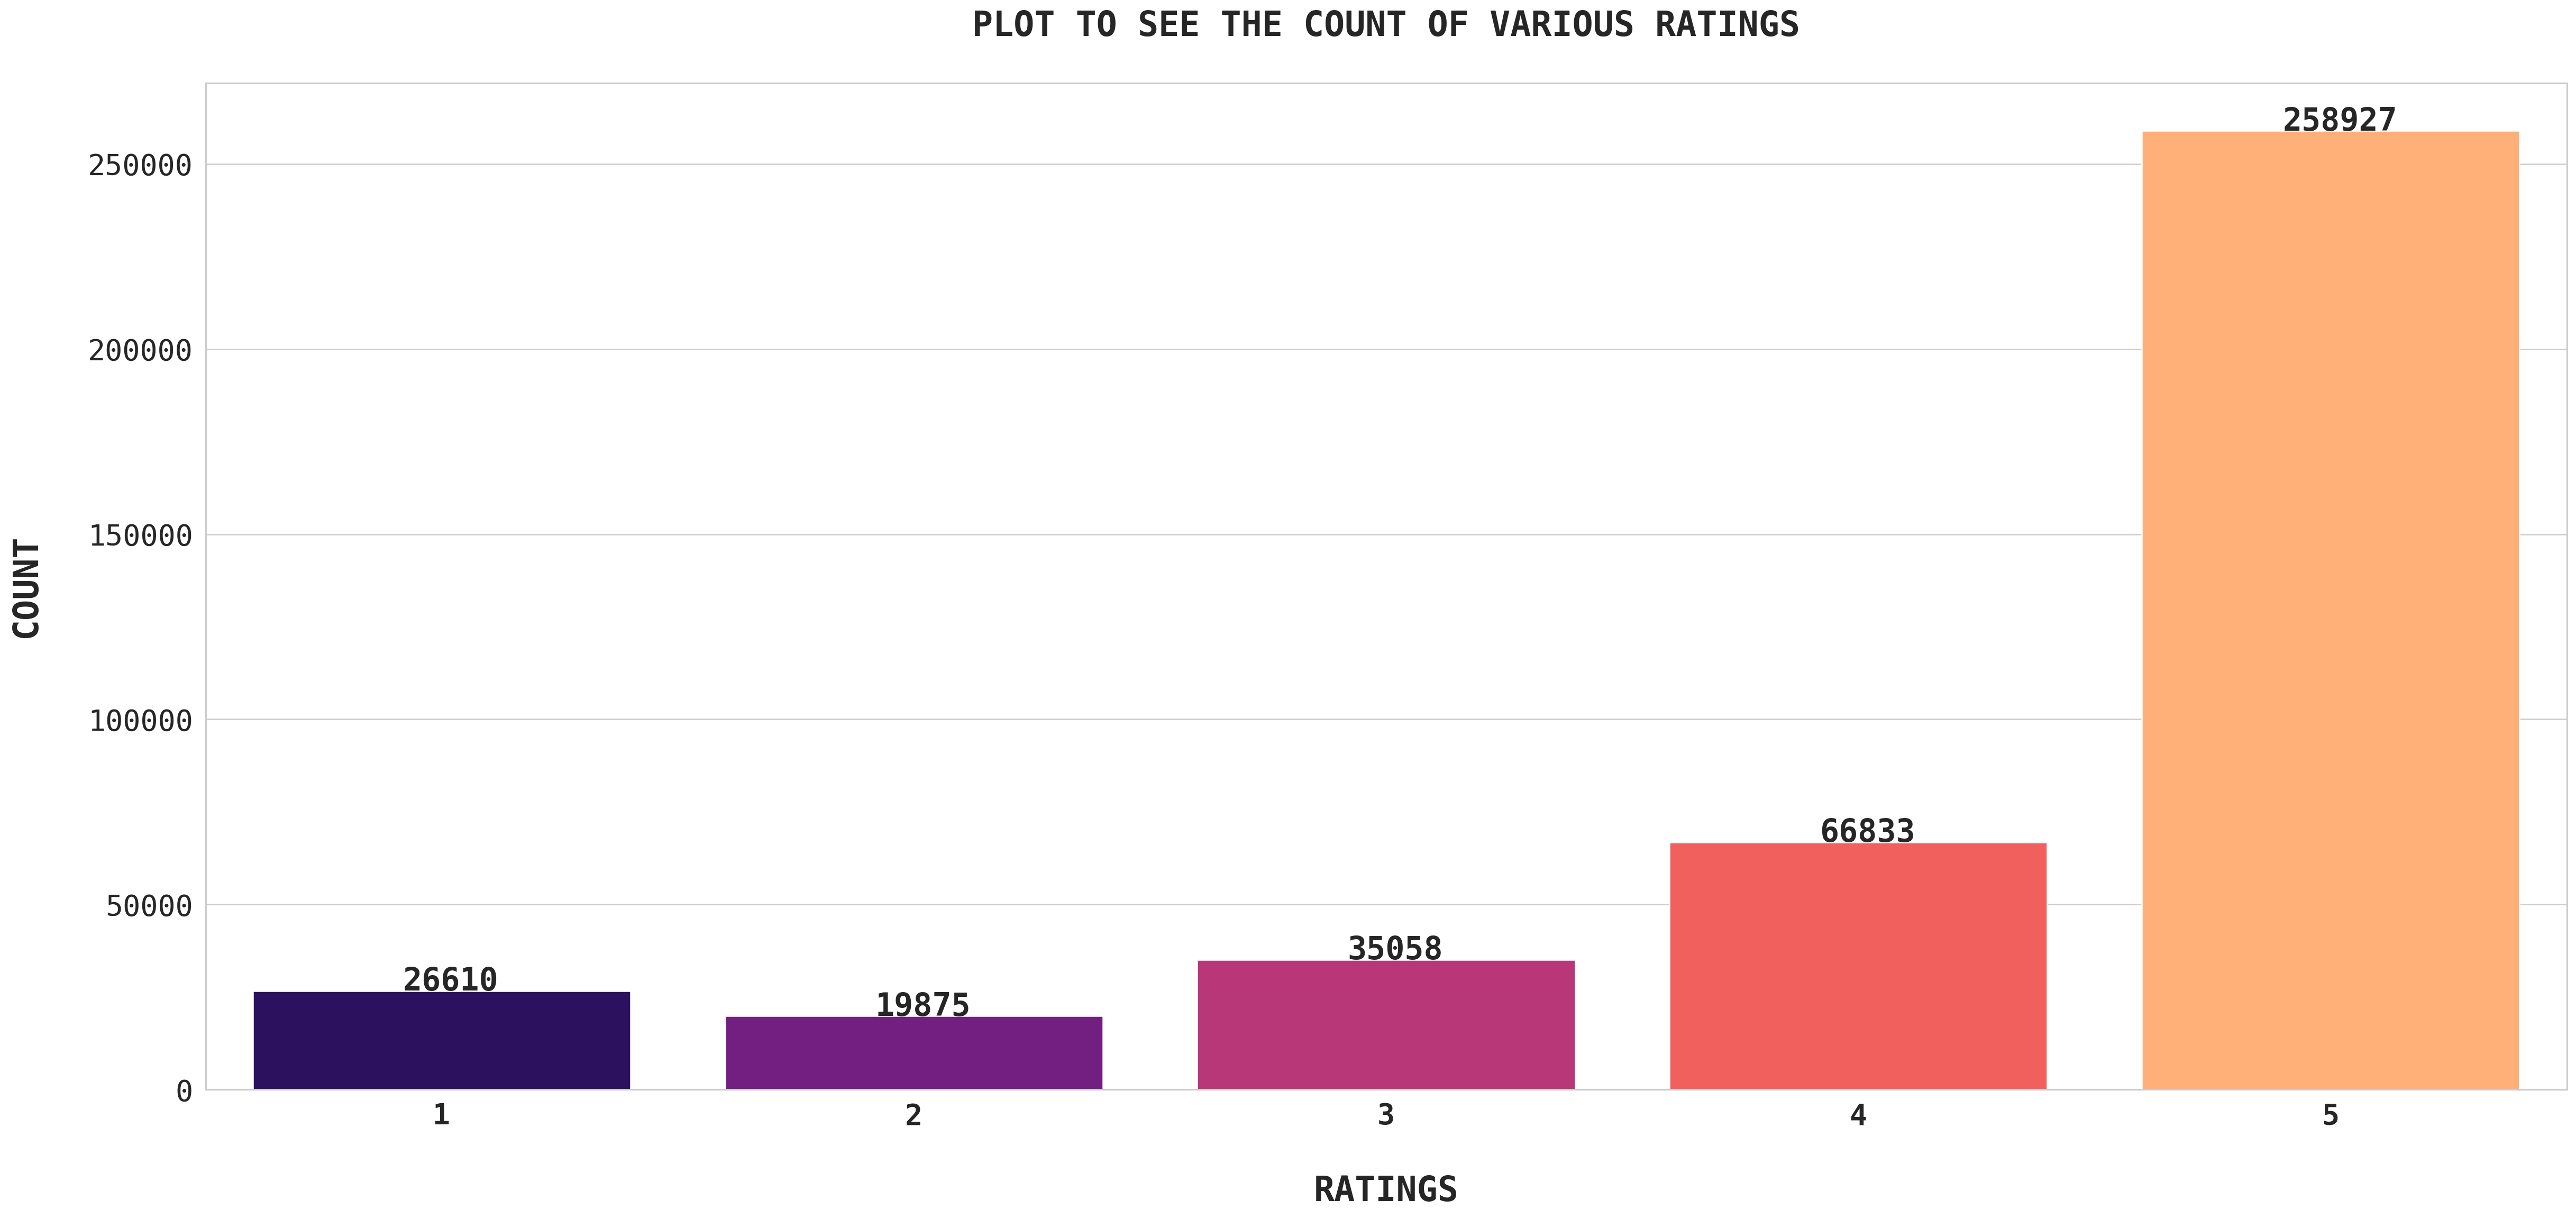

In [15]:
plt.figure(figsize=(32,14),dpi=180)
sns.set(context='notebook',style='whitegrid',palette='bright',font='monospace',font_scale=2)
m=sns.countplot(x='Rating',data=prod,orient='v',palette='magma',saturation=35)
m.set_xticklabels(m.get_xticklabels(),rotation=0,weight='bold')
for i in m.patches:
    m.annotate(format(i.get_height(),'.0f'),(i.get_x()+i.get_width()/2,i.get_height()),xytext=(7,7),ha='center',
                   weight='bold', rotation=0,va='center',textcoords='offset points')
plt.xlabel('\nRATINGS',fontsize=26,weight='bold')
plt.ylabel('COUNT\n',fontsize=26,weight='bold')
plt.title('PLOT TO SEE THE COUNT OF VARIOUS RATINGS\n',fontsize=26,weight='bold')

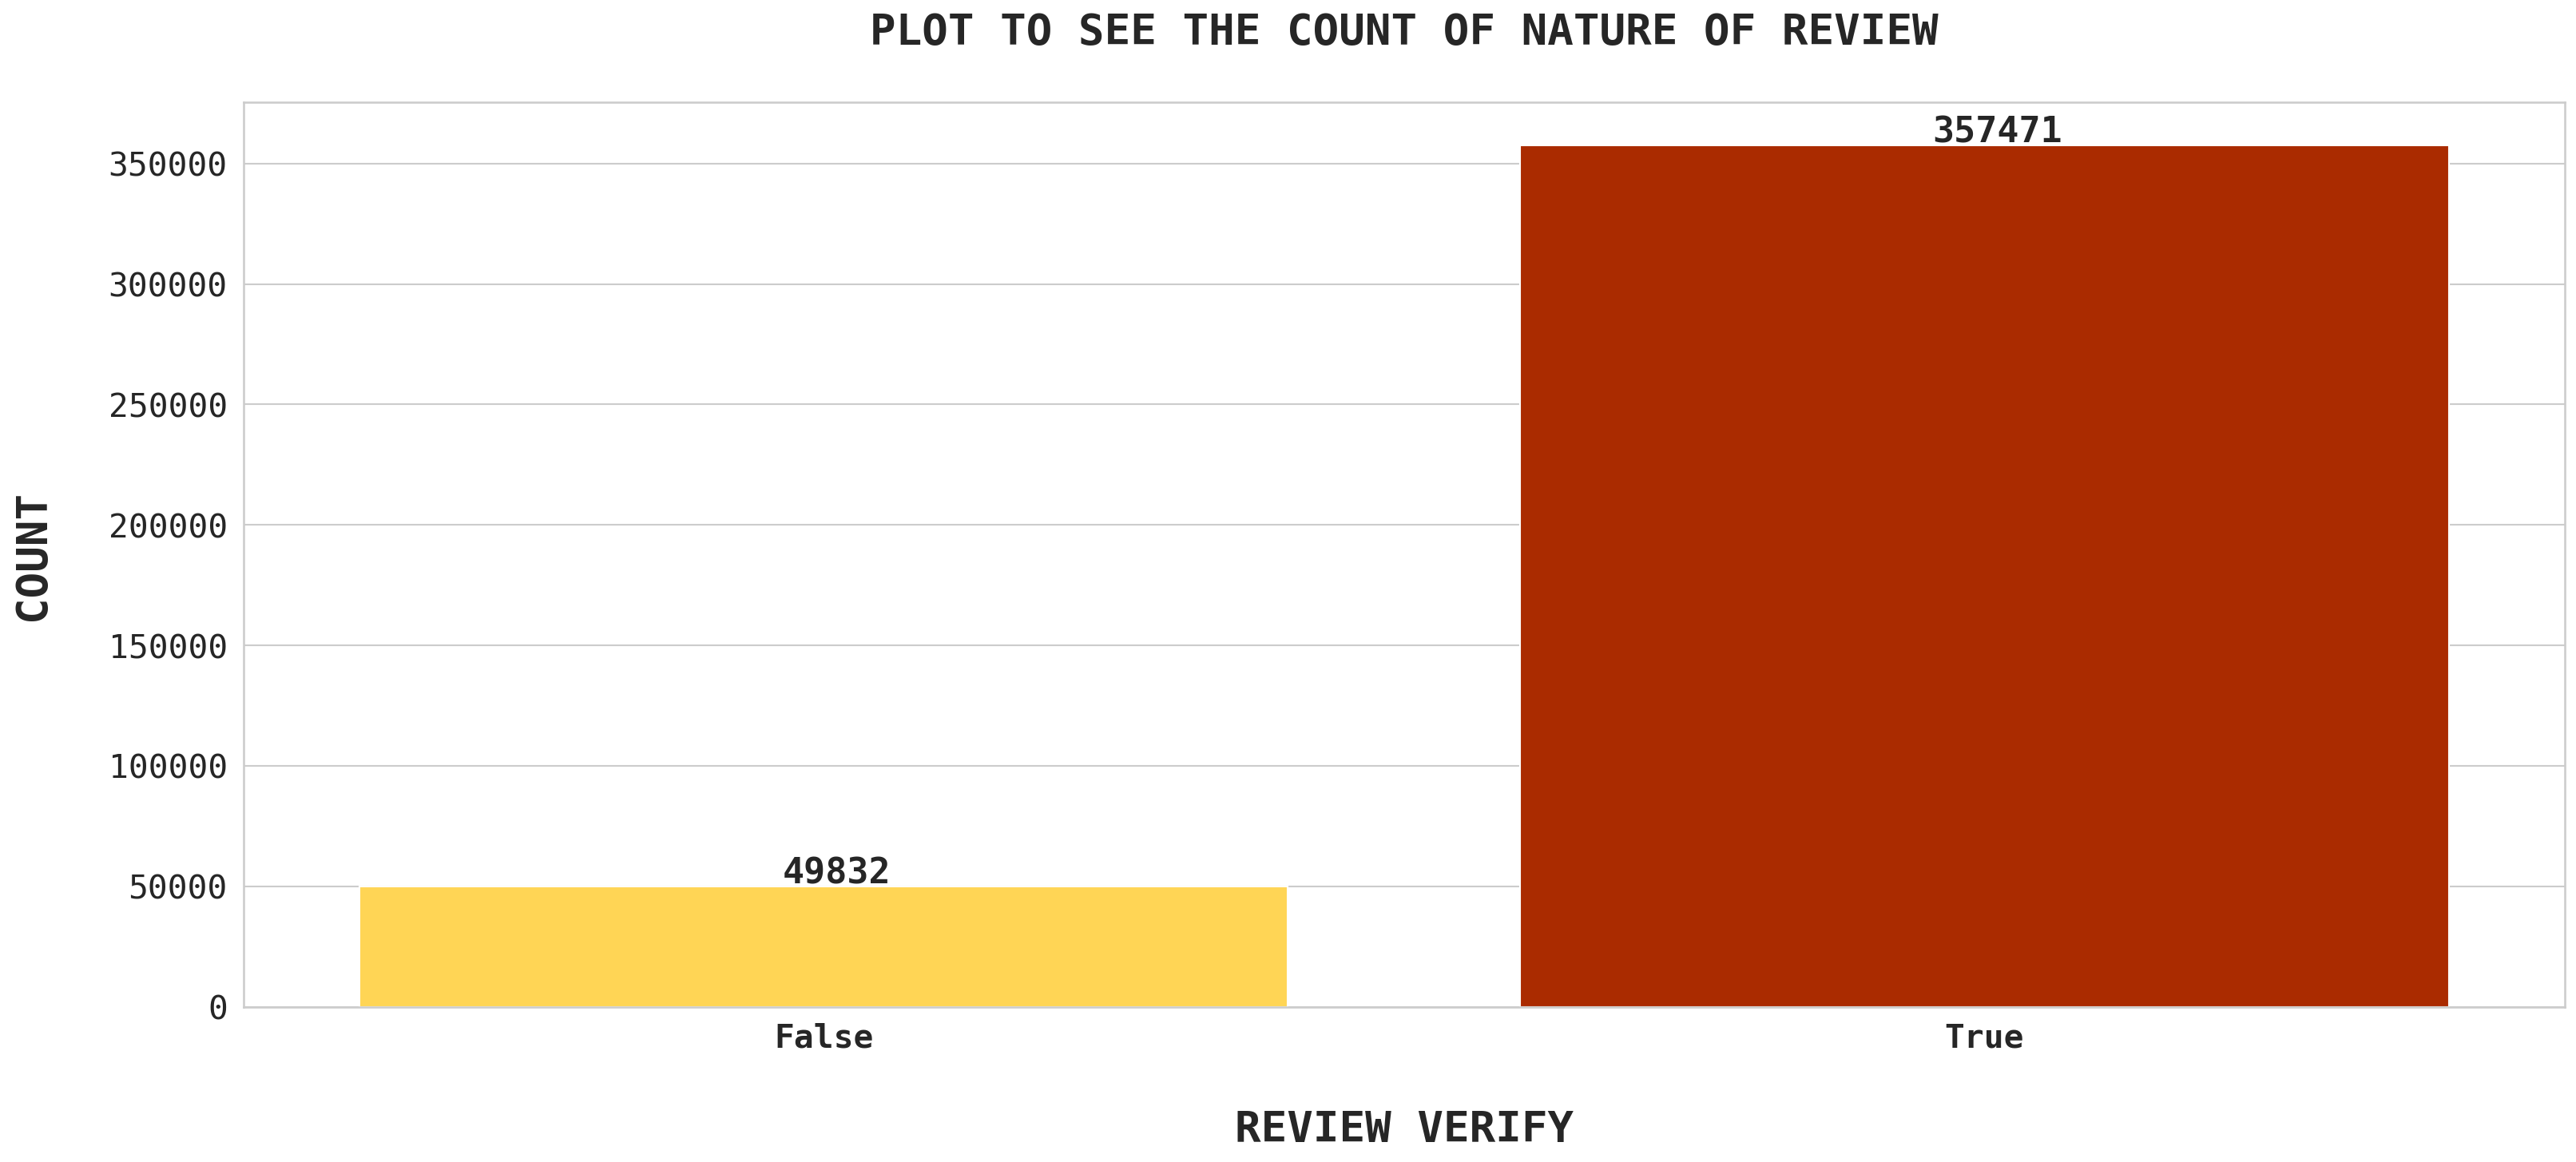

In [16]:
plt.figure(figsize=(25,10),dpi=150)
sns.set(context='notebook',style='whitegrid',palette='bright',font='monospace',font_scale=1.8)
m=sns.countplot(x='Rev_verify',data=prod,orient='v',palette='afmhot_r',saturation=35)
m.set_xticklabels(m.get_xticklabels(),rotation=0,weight='bold')
for i in m.patches:
    m.annotate(format(i.get_height(),'.0f'),(i.get_x()+i.get_width()/2,i.get_height()),xytext=(8,8),ha='center',
                   weight='bold', rotation=0,va='center',textcoords='offset points')
plt.xlabel('\nREVIEW VERIFY',fontsize=26,weight='bold')
plt.ylabel('COUNT\n',fontsize=26,weight='bold')
plt.title('PLOT TO SEE THE COUNT OF NATURE OF REVIEW\n',fontsize=26,weight='bold')
plt.show()

In [17]:
prod.describe(include=object)

TypeError: unhashable type: 'dict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'dict'


,IC,Reviewer_Name,Prod_meta,Review,Rev_summ
count,407303,407303,407303,407303,407303
unique,21012,112270,26250,346647,203408
top,B00VH88CJ0,Amazon Customer,{'Color:': ' Black'},good,Five Stars
freq,1124,14314,53893,2111,83556


### REMOVING REVIEWS WITH LESS THAN 3 WORDS

In [18]:
remove_reviews = []
index=[]
for i in range(len(prod)):
    reviews = str(prod["Review"][i])  
    
    reviews=reviews.split()
    
    if len(reviews)<3:
        remove_reviews.append(prod["Review"][i])
        index.append(i)

In [19]:
print('Length of unwanted reviews to be removed= ',len(remove_reviews))

Length of unwanted reviews to be removed=  49174


In [20]:
#visualizing reviews whose length are less than 3
sample=random.sample(remove_reviews,10)
sample

['Worked great',
 'Very nice.',
 'Good case',
 'very good',
 'EXCELENT',
 'Good',
 'muy bueno',
 'Excelente Producto!!!',
 'Too big',
 'As expected']

In [21]:
#dropping the values of rows where the length of review is less than 3
prod.drop(prod.index[index],inplace=True)

In [22]:
print('New shape after removal of small words=', prod.shape)

New shape after removal of small words= (358129, 8)


In [23]:
prod.reset_index(drop=True,inplace=True)

In [24]:
prod.head(6)

,IC,Reviewer_Name,Prod_meta,Review,Rev_summ,Rating,Review_Date,Rev_verify
0,B0089CH3TM,Alyse,{'Color:': ' Green'},"The material and fit is very nice, but the col...",Good case overall,3,2013-02-27,True
1,B00MAWPGMI,hannahv_tc,{'Color:': ' _Shimmery White'},"Love this case, very sturdy!",Five Stars,5,2016-12-22,True
2,B00NMR6N7W,Jacob,"{'Color:': ' Clear', 'Package Type:': ' Standa...",Great screen protector for the money! Paid $1....,Perfect!,5,2015-06-22,True
3,B018V60504,Metlman,{'Color:': ' Black'},"Nice charger. One problem, one if the two USB ...",Make sure your Items work before you miss the ...,5,2017-08-13,True
4,B00PG8TID6,A. Burke,"{'Color:': ' Black', 'Product Packaging:': ' S...",Most battery packs for iPhones come as a total...,This clever design combines a battery pack int...,5,2015-04-02,False
5,B00IJJCQBA,Stephanie,{'Color:': ' Black / Black'},To tight on my phone and the bottom piece was ...,One Star,1,2016-01-14,True


### VIEWING SOME REVIEWS ALONG WITH THEIR ICs & RATINGS GIVEN TO IT BY CUSTOMERS

In [25]:
for i in range(5):
    print("\n------Review of",prod['IC'][i],';')
    print(prod.Review[i].lower())
    print('--Rating =',prod.Rating[i])
    print('Given by',prod.Reviewer_Name[i].upper())
    print()


------Review of B0089CH3TM ;
the material and fit is very nice, but the color is more of a neon green than i expected or would have liked.
--Rating = 3
Given by ALYSE


------Review of B00MAWPGMI ;
love this case, very sturdy!
--Rating = 5
Given by HANNAHV_TC


------Review of B00NMR6N7W ;
great screen protector for the money! paid $1.50 with free shipping and it arrived way sooner than expected. fits perfect on my iphone 6 and looks better than the $15 screen protector i had on it before. i love the matte finish on it as well. it feels and looks better than the glossy ones. would most definitely buy again and recommend to anyone.
--Rating = 5
Given by JACOB


------Review of B018V60504 ;
nice charger. one problem, one if the two usb slots is misaligned, allowing only one charging slot to be used at a time.
only noticed after the return window was closed.
be very sure that your items are working, so you do not miss the return window. if something should happen after that, well that's 

### CHECKING AND PLOTTING THE MOST FREQUENT WORDS USED IN REVIEW SECTION

In [26]:
def frequency(text,no): 
    words = ' '.join([i for i in text])
    words=words.lower()
    words = words.split()
    distribution= FreqDist(words)  #checking repeation of words in a sentence
    df = pd.DataFrame({'word':list(distribution.keys()), 'count':list(distribution.values())})
    
    data = df.nlargest(columns="count", n = no) 
    
    plt.figure(figsize=(40,20),dpi=120)
    sns.set(context='notebook',style='whitegrid',palette='bright',font='monospace',font_scale=2)
    m=sns.barplot(x='word',y='count',data=data,orient='v',palette='autumn',saturation=35)
    m.set_xticklabels(m.get_xticklabels(),rotation=90,weight='bold')
    for i in m.patches:
        m.annotate(format(i.get_height(),'.0f'),(i.get_x()+i.get_width()/2,i.get_height()),xytext=(5,5),ha='center',
                   weight='bold', rotation=65,va='center',textcoords='offset points')
    plt.xlabel('\nWORDS',fontsize=27,weight='bold')
    plt.ylabel('COUNT\n',fontsize=27,weight='bold')
    plt.title('PLOT TO SEE THE COUNT OF WORDS\n',fontsize=27,weight='bold')
    plt.show()

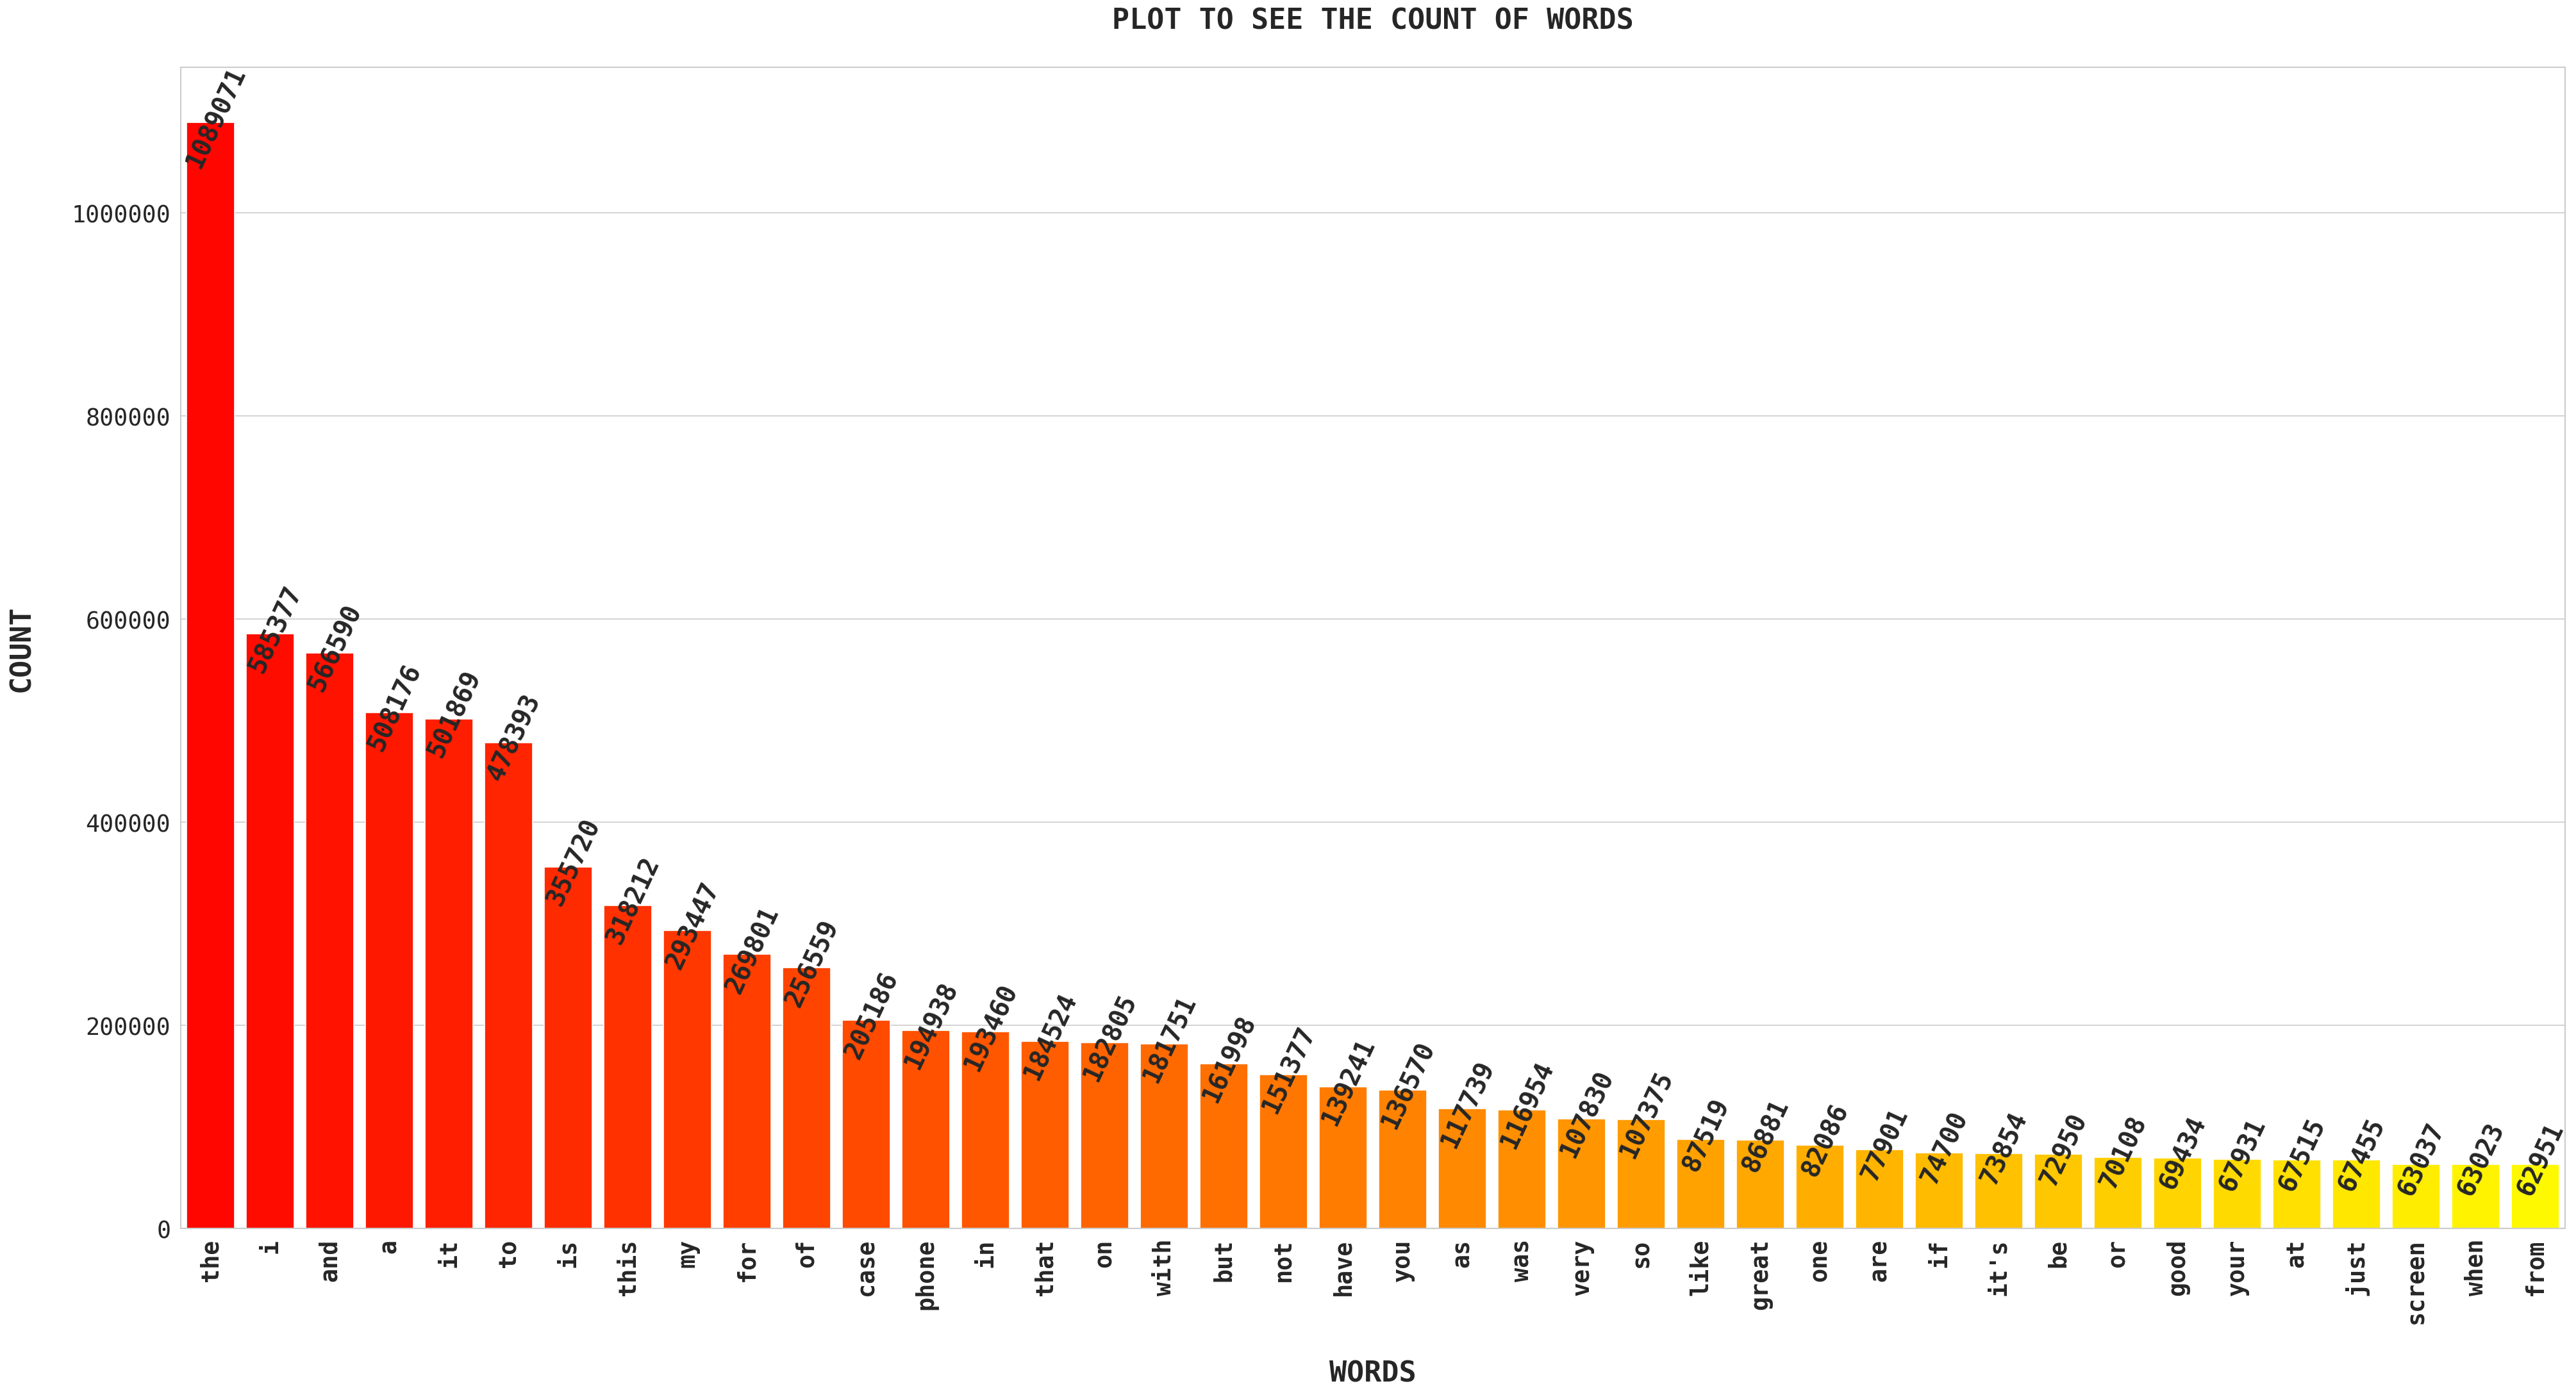

In [27]:
frequency(prod['Review'],no=40)

### PREPROCESSING THE 'REVIEW' COLUMN TO REMOVE STOPWORDS,SYMBOLS,PUNCTUATIONS ETC.

In [28]:
stopwords=['i','me','my','myself','we','our','ours','ourselves','you',"you're","you've","you'll","you'd",'href',
           'yours','yourself','yourselves','he','him','his','himself','she',"she's",'her','hers','link','your',
           'herself','it',"it's",'its','itself','they','them','their','theirs','themselves','what','which','linked','eventual'
           'who','whom','this','that',"that'll",'these','how','these','those','am','is','are','was','were','used','thiss',
           'be','been','being','have','has','had','having','do','does','did','done','doing','a','an','the','hold','week',
           'and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','know','tell',
           'between','into','through','during','before','after','above','below','to','from','up','down','in','out','based',
           'on','off','over','under','again','further','then','once','here','there','when','where','why','how','day','work',
           'all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','abov','soon',
           'so','than','too','very','s','t','can','will','just','don',"don't",'should',"should've",'now','d','ll','m','awhile',
           'o','re','ve','y','ain','aren',"aren't",'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'hadn','many','worked',
           "hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'mightn',"mightn't",'mustn',"mustn't",'needn','think','sometimes',
           "needn't",'shan',"shan't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn','cant','together',
           "wouldn't",'looked',"What's",'although','upright','bit','right','state',"i've",'much','more',"there's","You've",'add','added',
           'got',"i'd",'everything','true','yes','moreover','would','could','like','but','couldnt',"i'm",'able','back','adding',
           'get','still','ought','perhaps','without','away','onto','ive','must','see','went','saw','havent','whats','id','said',
           'let','never','yet','im','go','thatll','theyre','came','youll','come','word','noone','thank','thanks',"now!","then?",
           "that's","than",'is','more', 'so','on','can','all','as', 'a',"don't", "doesn't","it's","I'm","that's","there's",'know',
           'purchased','nice','take','year','purchased',"what's","where's","it's","who's","i'm","she's","he's","they're",'says',
           "who're","ain't","wouldn't","shouldn't","can't","couldn't","won't","will",'didnt','really','used','using','month','say',
           'received','hand','since','give','dont','well','doesnt','also','feel','enough','want','keep','made','around','even',
           'need','thing','another','seller','though','cant','however','make','protection','protect','take','protector','looking',
           'vary','easily','item','seems','days','different','bought','told','yesterday','others','something','everything','off','offs','take','took','taken',
          "wayyyy","wich","wold","wthe",'none','time','neither','nothing','website','therefore','become','every','wasnt','kept','always']


print("Length of stopwords=",len(stopwords))

Length of stopwords= 368


In [29]:
def preprocess(text):
    processed=[]
    
    lower=str(text).lower().replace(r'\n'," ").replace(r'\s+', ' ').replace(r'\d+(\.\d+)?', '')
    #removing \n,large white space and leading_trailing white spaces and numbers by single white space
    lower=lower.replace(r'^.+@[^\.].*\.[a-z]{2,}$',' ') #replacing any mailids by whitespace
    punct=lower.translate(str.maketrans('', '', string.punctuation))  #remove punctuation
    digit=punct.translate(str.maketrans('', '', string.digits))       #remove digits any remaining
    word= word_tokenize(digit, "english")    
    for i in word:
        if i not in stopwords and len(i)>3:   #considering token whose lenth
            lemma=WordNetLemmatizer().lemmatize(i)
            processed.append(lemma)
    return(" ".join([x for x in processed])).strip()

In [30]:
%%time
processed_docs = []
for i in prod.Review:
    processed_docs.append(preprocess(i))

Wall time: 3min 20s


In [31]:
print("Length of cleaned text=\t",len(processed_docs))
print(processed_docs[:21]) #CHECKING FIRST 6

Length of cleaned text=	 358129
['material color neon green expected liked', 'love case sturdy', 'great screen money paid free shipping arrived sooner expected fit perfect iphone look better screen love matte finish feel look better glossy one definitely recommend anyone', 'charger problem slot misaligned allowing charging slot noticed return window closed sure item working miss return window happen thats continue brick mortar store bestbuy', 'battery pack iphones totally separate device hunk plastic remember recharge lenmar iphone case actually becomes part iphone act battery pack work hard durable case remember charge phone separately phone case indefinitely phone battery pack recharge plug night phone battery start simply press green glowing button case recharges phone case indicates reserve battery power left might worry battery pack bulk iphone case half inch length inch thickness personally found problem size pocket bigger add surprisingly little weight case slip deal remove ofte

In [32]:
#CREATING A DATAFRAME
processed= pd.DataFrame({'Cleaned REVIEW' : processed_docs })

In [33]:
prod['cleaned_review']=processed

In [34]:
prod['Cleaned Review length']=prod['cleaned_review'].str.len()

In [35]:
prod.sample(3)

,IC,Reviewer_Name,Prod_meta,Review,Rev_summ,Rating,Review_Date,Rev_verify,cleaned_review,Cleaned Review length
222206,B00CJY94UW,Dog Mom,"{'Size:': ' HTC One M7', 'Color:': ' White/Bla...",I've had this case for over a month now and I ...,Love it!!!!,5,2014-02-03,True,case love hasnt scratched texture give good gr...,113
355974,B00NP25LYU,Tattedjew,{'Color:': ' Black'},Very nice case light weight and protects the p...,Great case,5,2016-04-02,False,case light weight protects phone kickstand gre...,73
124533,B00C96CMDG,kmuaxiong,{'Color:': ' Black.'},This is such a cheaper way of purchasing an ot...,Awesome!!!,5,2013-07-31,False,cheaper purchasing otter cover going store pur...,74


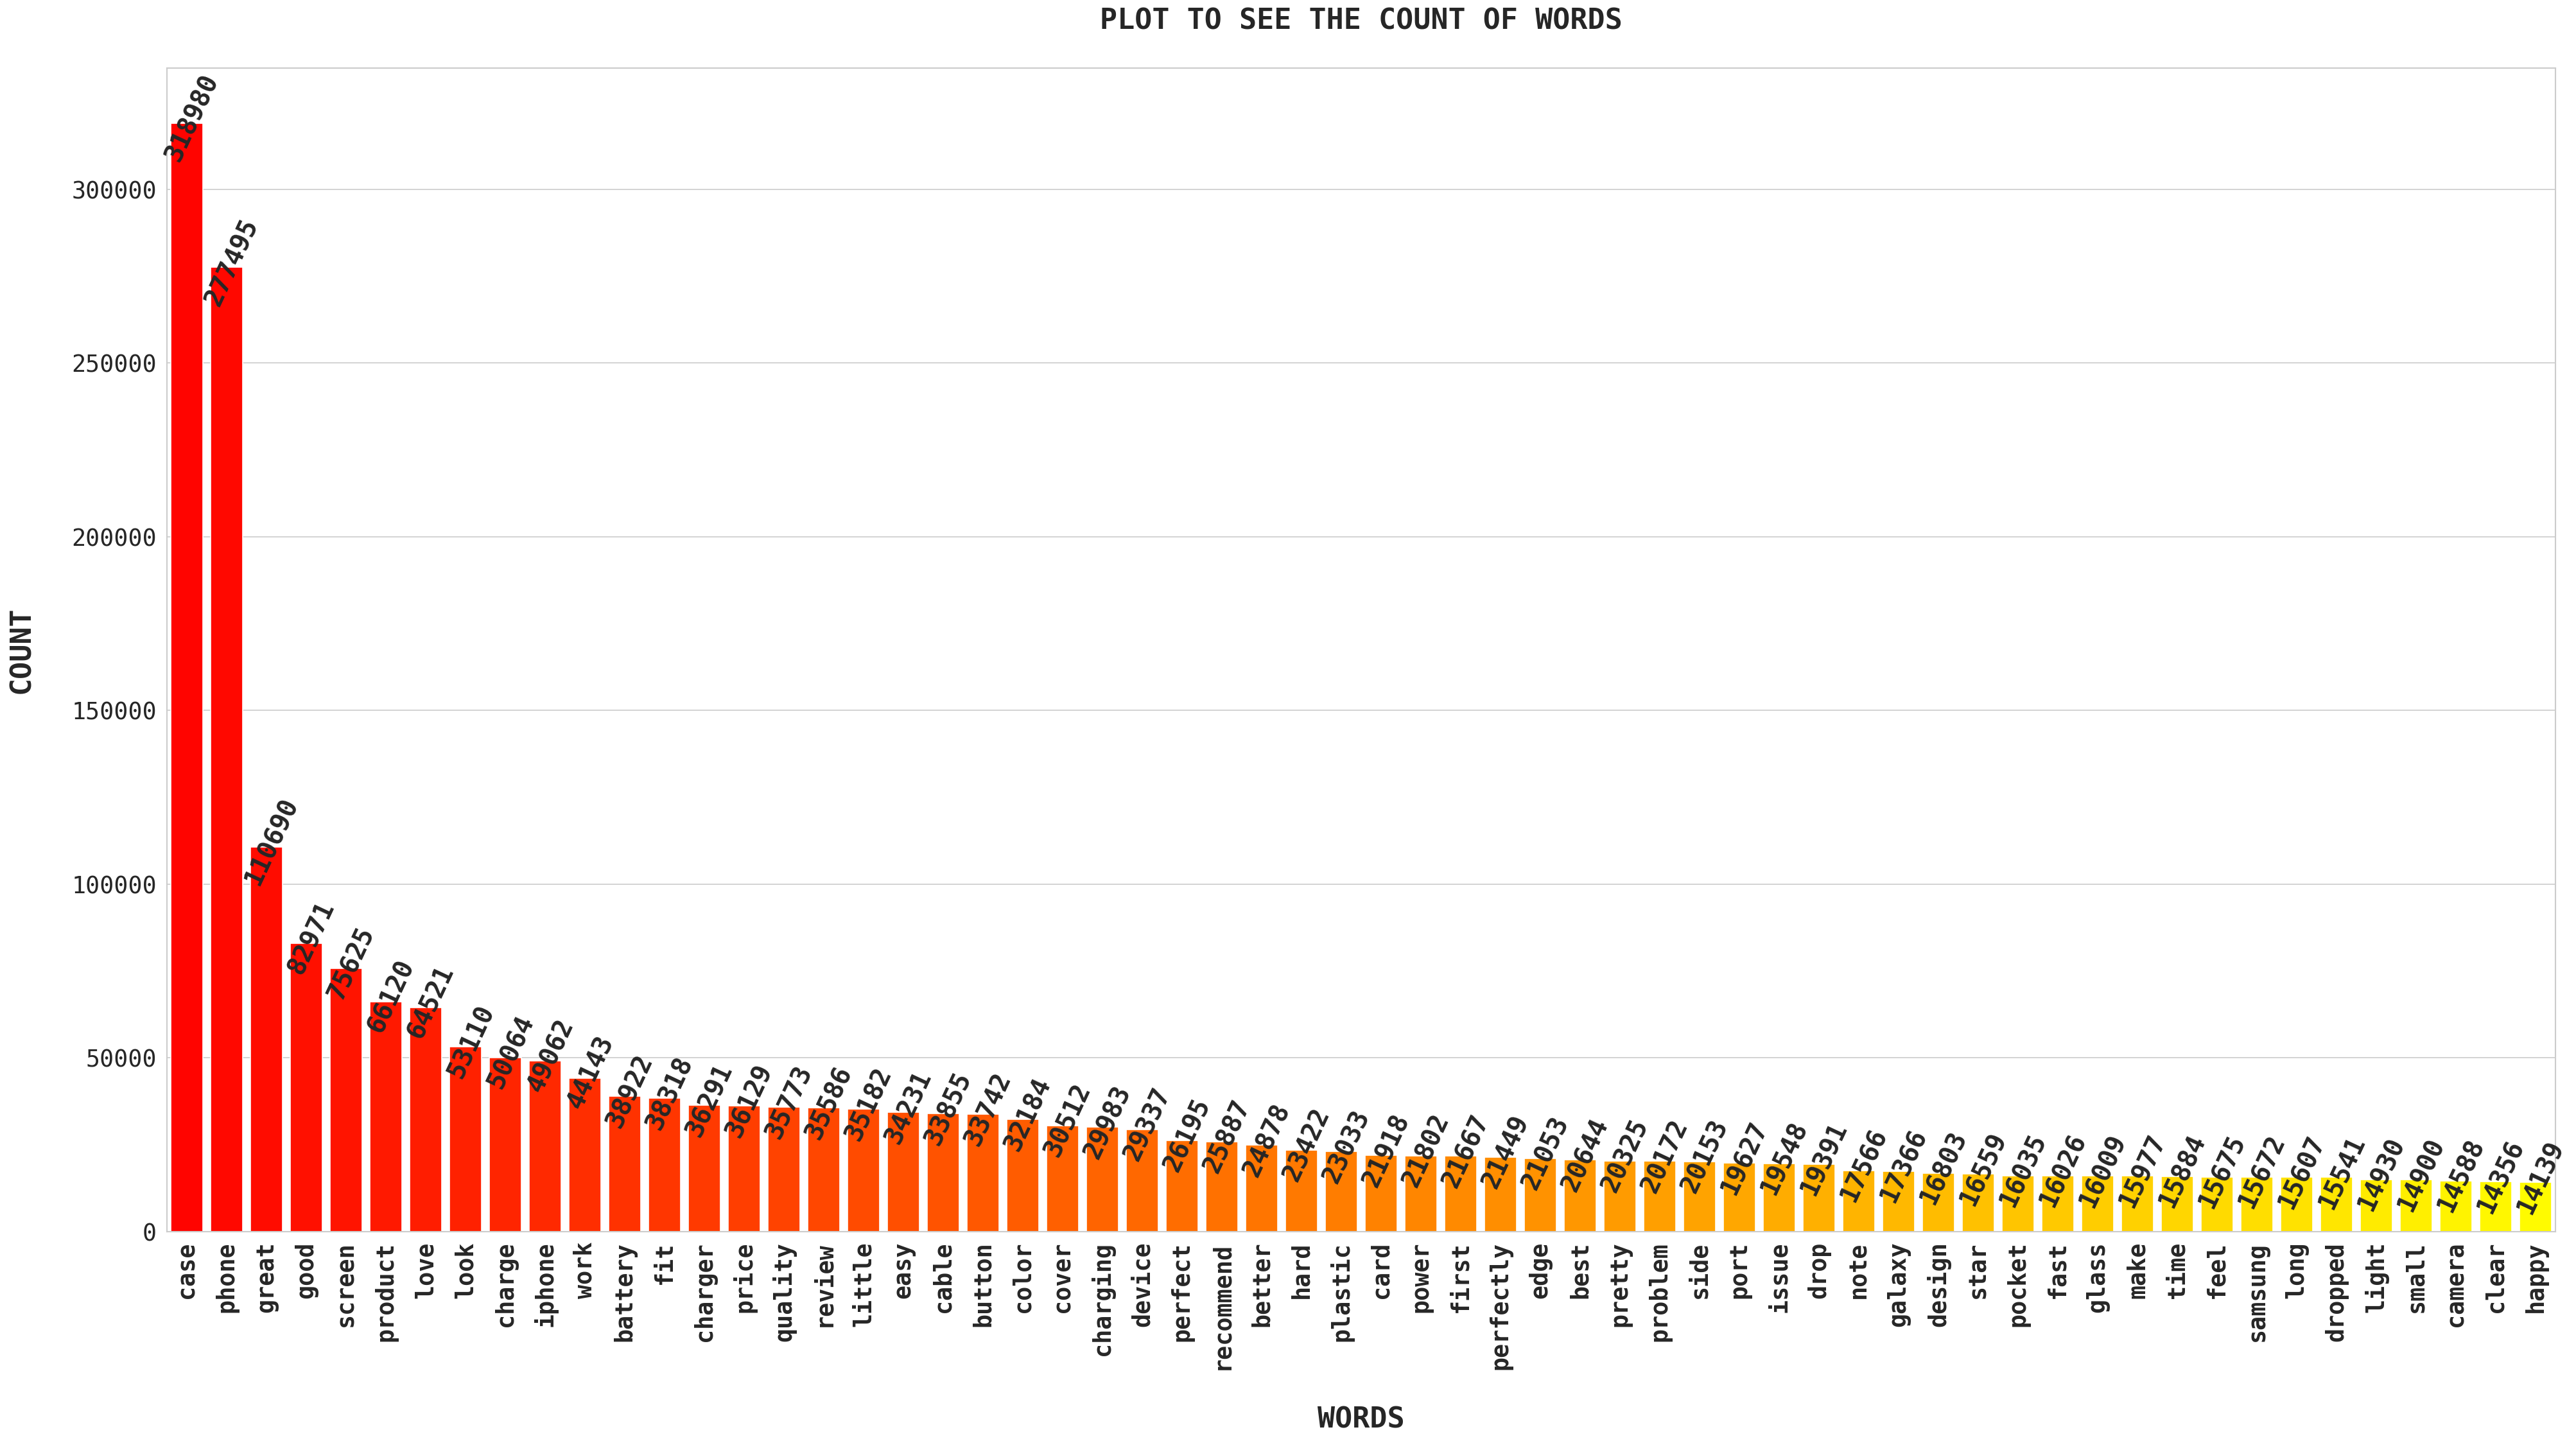

In [36]:
frequency(prod['cleaned_review'],no=60)

###### CREATING A NEW DATAFRAME CONTAINING UNIQUE ICs, REVIEWS FOR EACH ICs, TOTAL RATING GIVEN TO EACH PRODUCT

COLUMN NAMED  "maximum" ,WILL CONTAIN THE SUM OF NUMBERS OF 5 & 4 STAR RATINGS GIVEN TO A PRODUCT BY CUSTOMERS

COLUMN NAMED  "average" ,WILL CONTAIN THE SUM OF NUMBERS ONLY OF 3 STAR RATINGS GIVEN TO A PRODUCT BY CUSTOMERS

COLUMN NAMED  "minimum" ,WILL CONTAIN THE SUM OF NUMBERS OF 2 & 1 STAR RATINGS GIVEN TO A PRODUCT BY CUSTOMERS

In [37]:
ic=prod["IC"].value_counts().index.tolist()

In [38]:
len(ic)

20948

In [39]:
%%time
dictionary={}
dictionary['IC']=[]
dictionary['DESCRIPTION']=[]
dictionary['REVIEW']=[]
dictionary['MAXIMUM']=[]
dictionary['AVERAGE']=[]
dictionary['MINIMUM']=[]

for x in ic:
    i=0
    j=0
    k=0
      
    dictionary['IC'].append(x)   
                                                    #it'll contain the unique ICs of the product
    
    desc=prod.loc[prod['IC']==x,'Prod_meta'].values
    dictionary['DESCRIPTION'].append(desc[0])
                                                    
                                                    #it'll contain the meta data for each product 
    review=prod.loc[prod['IC']==x,'cleaned_review'].values
    review=str(list(review))
    dictionary['REVIEW'].append(review)                          
        #it'll contain all the preprocessed and cleaned review for each product in a single cell
    
    rates=prod.loc[prod['IC']==x,'Rating'].values
    for rate in rates:
        if rate>3:
            i=i+1 
        #'i' will contain the total number of 5 and 4 star given to a product & will be dispalyed on column 'maximum'
    
        elif rate==3:
            j=j+1            
        #'j' will contain the total number of 3 star given to a product & will be dispalyed on column 'average'
   
        else:
            k=k+1            
        #'k' will contain the total number of 2 and 1 star given to a product & will be dispalyed on column 'minimum'
                
    dictionary['MAXIMUM'].append(i)  
    dictionary['AVERAGE'].append(j)
    dictionary['MINIMUM'].append(k)


Wall time: 24min 49s


In [40]:
print('NUMBER OF UNIQUE IC= ',len(dictionary['IC']),'\nNUMBER OF REVIEWS= ',len(dictionary['REVIEW']))

NUMBER OF UNIQUE IC=  20948 
NUMBER OF REVIEWS=  20948


In [41]:
crit=pd.DataFrame(dictionary)

### GENERATING A FUNCTION TO PREPROCESS THE DATA AND CREAT LEMMATIZED TOKENS OUT OF THEM

In [42]:
def preprocess(text):
    processed=[]
    text=text.lower().replace(r'\n'," ").replace(r'\s+', ' ').replace(r'\d+(\.\d+)?', '') 
     #removing \n,large white space and leading_trailing white spaces and numbers by single white space
           
    punct=text.translate(str.maketrans('', '', string.punctuation))  #remove punctuation
    digit=punct.translate(str.maketrans('', '', string.digits))      #remove digits
    word= word_tokenize(digit, "english")
    for i in word:
        if i not in stopwords and len(i)>=3:
            lemma=WordNetLemmatizer().lemmatize(i)
            processed.append(lemma)
    return processed

### ADDING TOKENISED WORDS TO THE MAIN DATAFRAME

In [43]:
crit['TOKENIZED_REVIEW'] = crit['REVIEW'].apply(preprocess)

In [44]:
crit.sample(5)

,IC,DESCRIPTION,REVIEW,MAXIMUM,AVERAGE,MINIMUM,TOKENIZED_REVIEW
16129,B0183RIOXG,"{'Size:': ' iPhone 6 / 6s 4.7 Inch', 'Color:':...",['wife loved cute little puffball actually ser...,3,0,1,"[wife, loved, cute, little, puffball, actually..."
1184,B00NOGWIBG,{'Color:': ' ArmorBox White'},['gave daughterinlaw love show dirt white part...,37,6,12,"[gave, daughterinlaw, love, show, dirt, white,..."
3355,B009H0OW4Y,"{'Offer Type:': ' Case Friendly', 'Package Typ...",['generally happy product phone pretty clear p...,19,0,5,"[generally, happy, product, phone, pretty, cle..."
13955,B01D9K7GUE,"{'Size:': ' Samsung Galaxy S7 Edge', 'Color:':...","['love love love kind case hooked', 'product e...",3,1,1,"[love, love, love, kind, case, hooked, product..."
3518,B01G687VV0,{'Color:': ' Red'},['package first noticed case texture smaller i...,16,5,2,"[package, first, noticed, case, texture, small..."


In [45]:
processed=crit.TOKENIZED_REVIEW

In [46]:
#creating a dictionary
dictionary = gensim.corpora.Dictionary(processed)

In [47]:
print (dictionary)

Dictionary(95659 unique tokens: ['ability', 'abroad', 'absence', 'absolute', 'absolutely']...)


In [48]:
#checking the first 30 key value pairs of the dictionary created
count=0
for k,v in dictionary.iteritems():
    print (k, v)
    count +=1
    if count >15:
        break

0 ability
1 abroad
2 absence
3 absolute
4 absolutely
5 acceptable
6 accepted
7 access
8 accessory
9 accident
10 accidental
11 accidentally
12 accidently
13 accommodate
14 accordingly
15 account


In [49]:
#removing rare and repetitive words
dictionary.filter_extremes(no_below=3,no_above=0.02,keep_n=95000)

In [50]:
print (dictionary)

Dictionary(22781 unique tokens: ['abroad', 'absence', 'acceptable', 'accepted', 'accidently']...)


In [51]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

In [52]:
#preview of words and their apperance in the topics
document_num = 1
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]],
                                                     bow_doc_x[i][1]))

Word 5 ("accordingly") appears 2 time.
Word 11 ("adaptive") appears 1 time.
Word 12 ("address") appears 1 time.
Word 23 ("airport") appears 1 time.
Word 29 ("amazed") appears 1 time.
Word 33 ("amp") appears 28 time.
Word 34 ("ampere") appears 2 time.
Word 39 ("anger") appears 1 time.
Word 40 ("ankerdirect") appears 3 time.
Word 41 ("ankers") appears 21 time.
Word 47 ("anybody") appears 1 time.
Word 48 ("apologized") appears 1 time.
Word 52 ("appropriate") appears 2 time.
Word 57 ("assorted") appears 1 time.
Word 61 ("astro") appears 1 time.
Word 70 ("automatic") appears 2 time.
Word 76 ("backed") appears 1 time.
Word 99 ("bike") appears 1 time.
Word 106 ("blow") appears 3 time.
Word 109 ("boost") appears 3 time.
Word 112 ("brag") appears 1 time.
Word 113 ("braided") appears 2 time.
Word 115 ("breeze") appears 1 time.
Word 117 ("brightness") appears 3 time.
Word 125 ("burn") appears 1 time.
Word 126 ("burned") appears 1 time.
Word 130 ("camping") appears 3 time.
Word 140 ("certified") a

## LDA MODEL

In [53]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 35, 
                                   id2word = dictionary,                                    
                                   passes =15)

#### Here num_topics is the number of topics to be created and passes is the number of times the iteration to be done on the entire corpus created.

In [54]:
for idx, topic in lda_model.print_topics():
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 29 
Words: 0.034*"supcase" + 0.014*"mouse" + 0.012*"beetle" + 0.012*"unicorn" + 0.003*"bastex" + 0.003*"latch" + 0.003*"rainbow" + 0.003*"hinge" + 0.002*"scanner" + 0.002*"handed"


Topic: 23 
Words: 0.020*"macro" + 0.016*"wheel" + 0.012*"steering" + 0.010*"fish" + 0.008*"tour" + 0.006*"storm" + 0.006*"fisheye" + 0.006*"keychain" + 0.005*"lense" + 0.005*"giant"


Topic: 27 
Words: 0.090*"antenna" + 0.047*"bar" + 0.044*"booster" + 0.021*"boost" + 0.018*"wilson" + 0.016*"tower" + 0.016*"roof" + 0.009*"weboost" + 0.007*"indoor" + 0.007*"mounted"


Topic: 24 
Words: 0.017*"zagg" + 0.014*"mirror" + 0.008*"glare" + 0.007*"alcohol" + 0.007*"halo" + 0.006*"microfiber" + 0.006*"particle" + 0.005*"adhere" + 0.005*"invisible" + 0.005*"privacy"


Topic: 4 
Words: 0.080*"selfie" + 0.063*"tripod" + 0.036*"remote" + 0.015*"shutter" + 0.014*"clamp" + 0.014*"leg" + 0.013*"selfies" + 0.008*"gopro" + 0.007*"pole" + 0.007*"monopod"


Topic: 13 
Words: 0.032*"usbc" + 0.023*"braided" + 0.017*"fiber" 

### PLOT TO CHECK THE IMPORTANT WORDS PER TOPIC

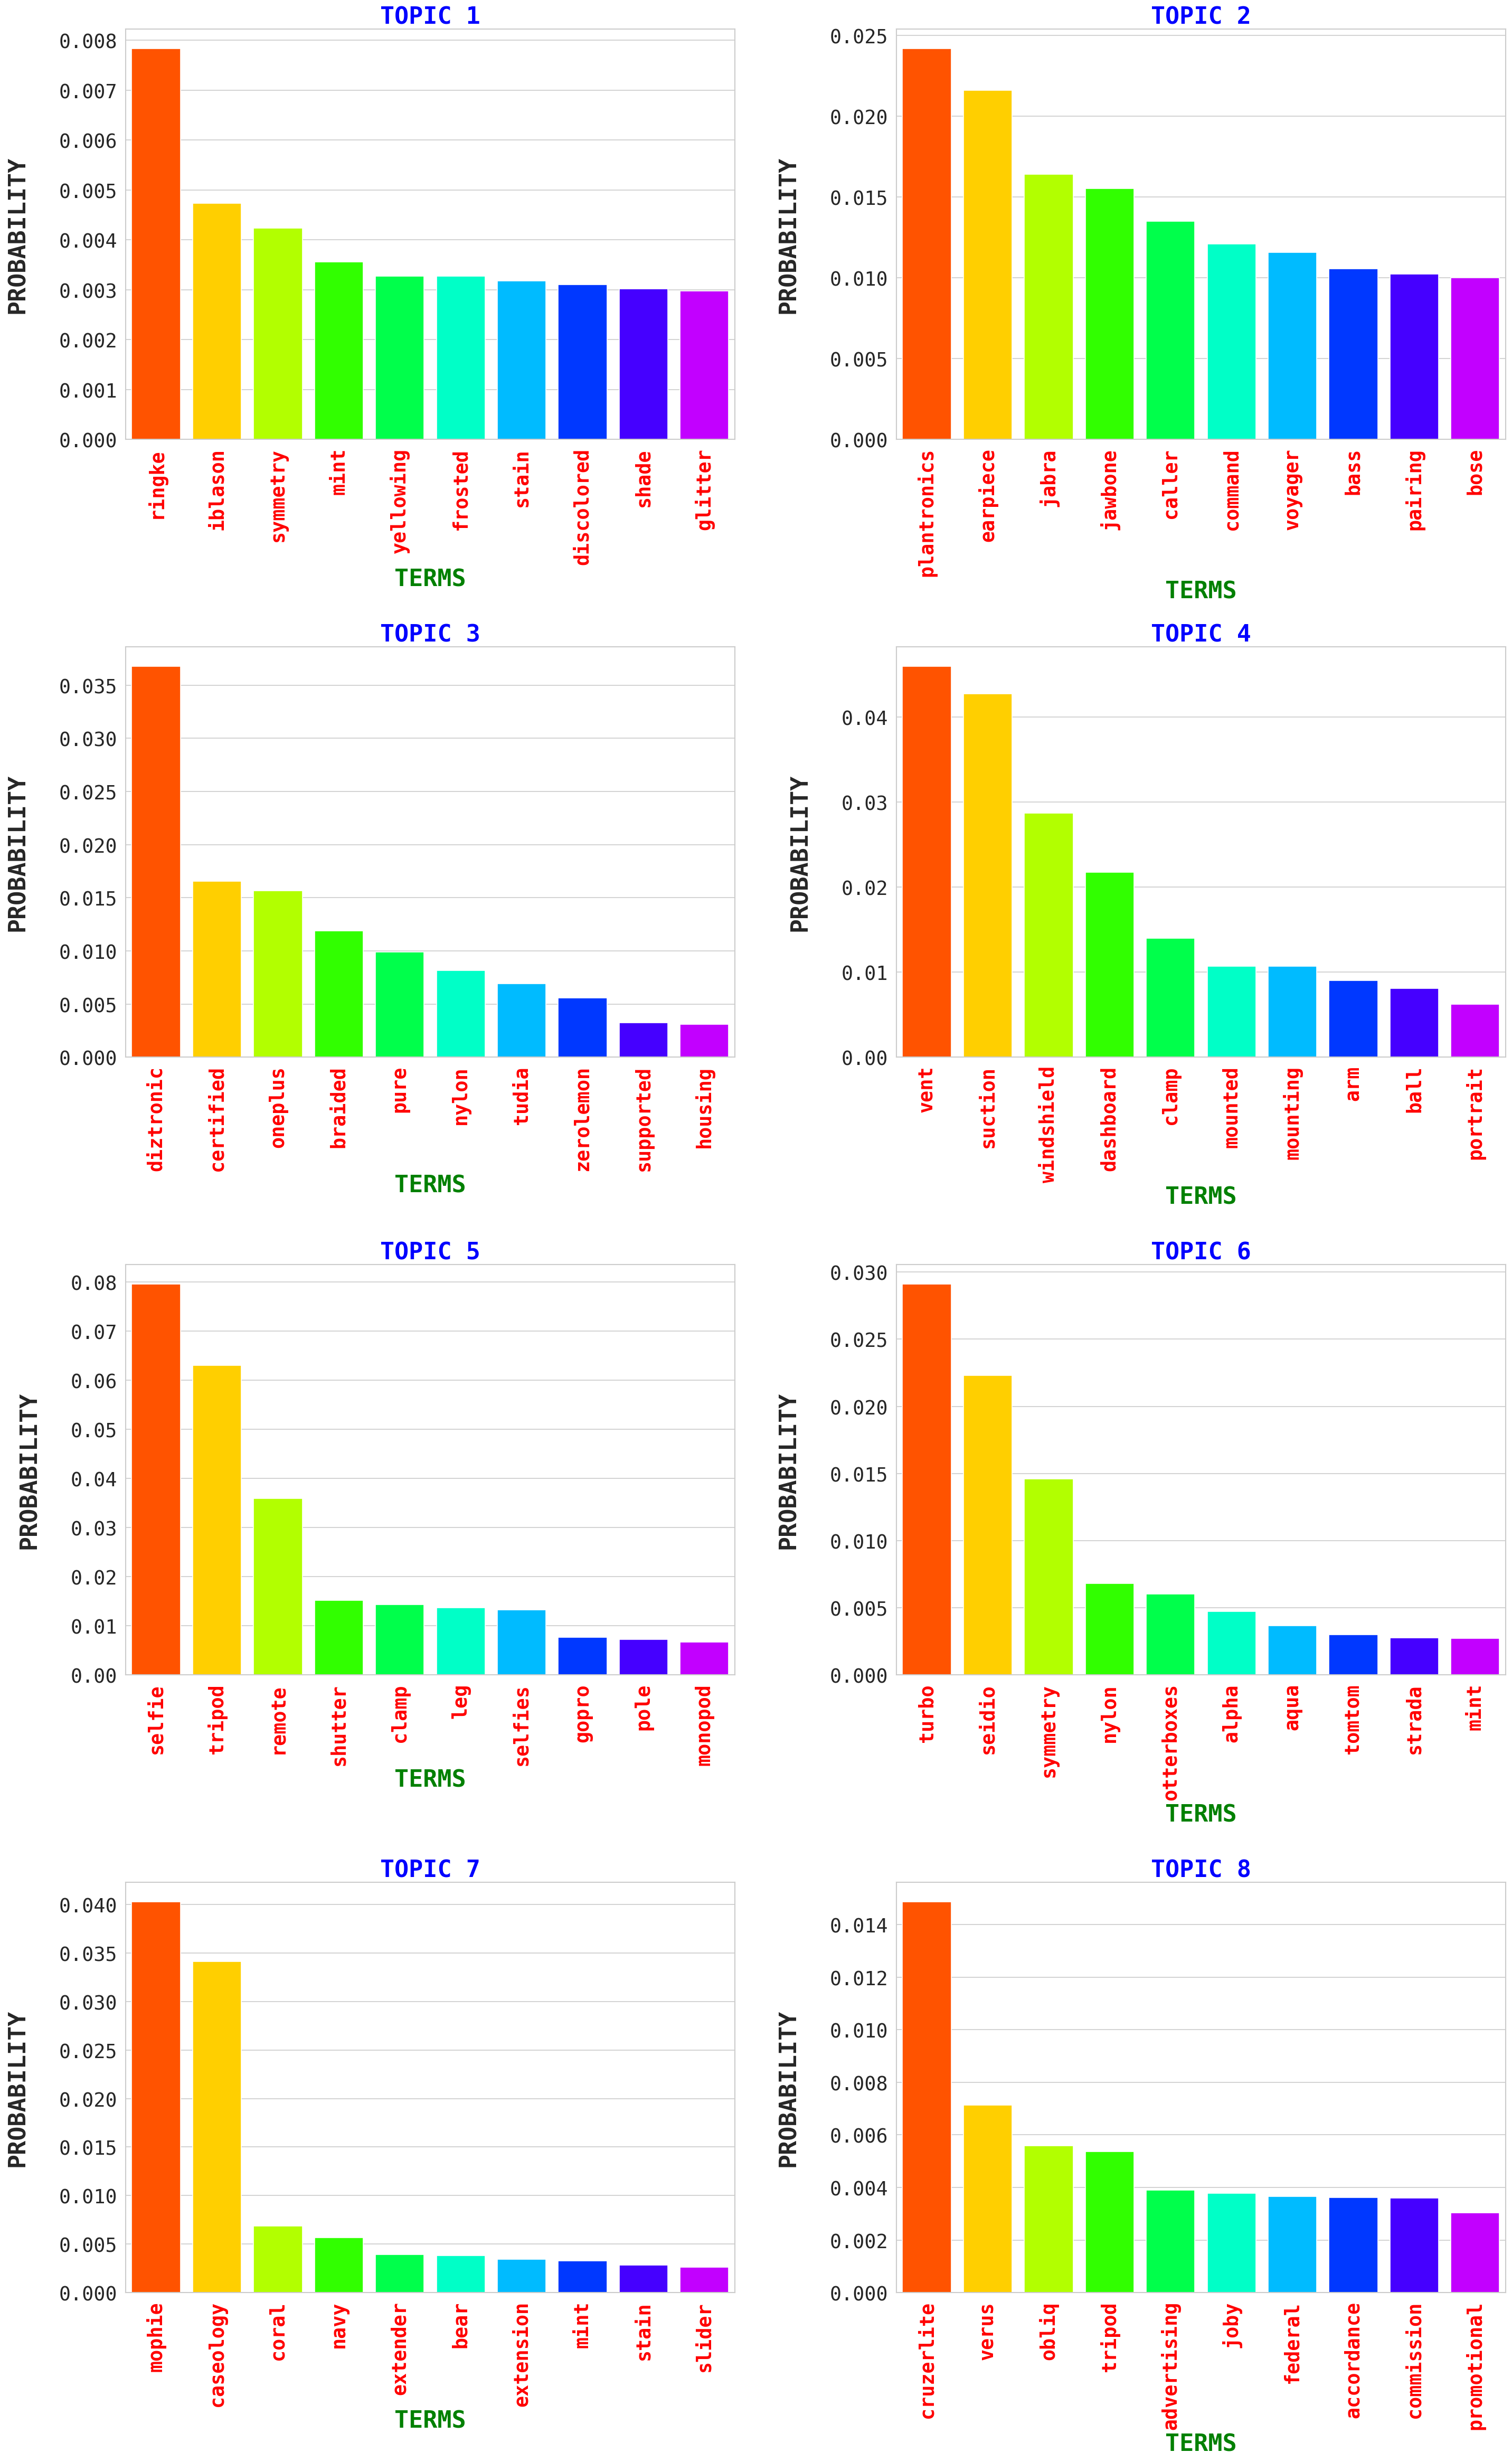

In [55]:
plt.figure(figsize=(25,40),dpi=120)
sns.set(context='notebook',style='whitegrid',palette='dark',font='monospace',font_scale=2)
for i in range(8): #showing 10 topics
    topic=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob'])    
    plt.subplot(4,2,i+1)
    topics='TOPIC '+str(i+1)+''
    m=sns.barplot(y='prob', x='term', data=topic, palette='gist_rainbow',saturation=35)
    m.set_xticklabels(m.get_xticklabels(),rotation=90,weight='bold',color='red')
    plt.title(topics,fontsize=27,weight='bold',color='blue')          
    plt.xlabel('TERMS',fontsize=27,weight='bold',color='green')
    plt.ylabel('PROBABILITY\n',fontsize=27,weight='bold')
plt.tight_layout(pad=2, h_pad=1, w_pad=2)
plt.show()

In [56]:
def dominant_topic(ldamodel, corpus, texts):

    sent_topics_df = pd.DataFrame() 

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:# =&gt; dominant topic
                wp = ldamodel.show_topic(topic_num,topn=30)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Topic', 'Perc', 'Keys']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [57]:
dominant = dominant_topic(ldamodel=lda_model, corpus=bow_corpus, texts=crit['REVIEW'])

In [58]:
dominant.drop(['REVIEW'],axis=1,inplace=True)

In [59]:
Final=pd.concat([crit,dominant],axis=1)

In [60]:
Final.head(10)

,IC,DESCRIPTION,REVIEW,MAXIMUM,AVERAGE,MINIMUM,TOKENIZED_REVIEW,Topic,Perc,Keys
0,B005NF5NTK,{'Color:': ' Black'},['performance poor babysit turn stop charging ...,871,51,59,"[performance, poor, babysit, turn, stop, charg...",25.0,0.8953,"amp, flashlight, led, ipads, astro, recharging..."
1,B00VH88CJ0,{'Color:': ' Black'},"['good charger', 'love charger anker home char...",915,19,31,"[good, charger, love, charger, anker, home, ch...",25.0,0.6522,"amp, flashlight, led, ipads, astro, recharging..."
2,B019PV2I3G,"{'Size:': ' 6ft', 'Color:': ' Red'}","['love cheep feeling product', 'short highly d...",856,23,56,"[love, cheep, feeling, product, short, highly,...",13.0,0.8095,"usbc, braided, fiber, powerline, carbon, pixel..."
3,B00X5RV14Y,{'Color:': ' Black'},"['charge droid ipad', 'power house work easy c...",881,24,20,"[charge, droid, ipad, power, house, easy, carr...",25.0,0.8537,"amp, flashlight, led, ipads, astro, recharging..."
4,B00P7N0320,{'Color:': ' Black'},"['charge phone perfectly look pretty', 'arrive...",869,20,29,"[charge, phone, perfectly, look, pretty, arriv...",25.0,0.8384,"amp, flashlight, led, ipads, astro, recharging..."
5,B018JW3EOY,{'Color:': ' Black'},"['battery often fit bill carrying', 'birthday ...",866,22,30,"[battery, often, fit, bill, carrying, birthday...",25.0,0.8406,"amp, flashlight, led, ipads, astro, recharging..."
6,B00MQSMDYU,{'Color:': ' Black-16750'},['update issue registration corrected star hap...,750,24,45,"[update, issue, registration, corrected, star,...",25.0,0.6568,"amp, flashlight, led, ipads, astro, recharging..."
7,B00G7UY3EG,{'Format:': ' Wireless Phone Accessory'},"['work good product happy', 'galaxy prefer cha...",599,29,121,"[good, product, happy, galaxy, prefer, chargin...",13.0,0.3135,"usbc, braided, fiber, powerline, carbon, pixel..."
8,B00D856NOG,{'Color:': ' Black'},['little phone stand prop phone ordered wife n...,643,24,23,"[little, phone, stand, prop, phone, ordered, w...",3.0,0.3200,"vent, suction, windshield, dashboard, clamp, m..."
9,B0092KJ9BU,"{'Color:': ' Black', 'Package Type:': ' Standa...",['excellent bluetooth piece simply best contro...,505,67,105,"[excellent, bluetooth, piece, simply, best, co...",1.0,0.7799,"plantronics, earpiece, jabra, jawbone, caller,..."


#### Saving the model

In [61]:
joblib.dump(lda_model,'productreview.pkl')

['productreview.pkl']

In [62]:
Final.to_json(r'C:\Users\SAURABH UPADHYAY\Review\REVIEW.json')